In [1]:
import pandas as pd
import os

In [6]:
project_folder = os.path.abspath('.')
data_folder = os.path.join(project_folder, "data")
trainset_file = os.path.join(data_folder, "DBLPTrainset.txt")
testset_file = os.path.join(data_folder, "DBLPTestset.txt")
ground_truth_file = os.path.join(data_folder, "DBLPTestGroundTruth.txt")

out_folder = os.path.join(project_folder, "out")
SEED = 46532

In [7]:
dataset_train = pd.read_table(os.path.join(trainset_file), sep="\t", header=None, names=['y', 'X'],
                              index_col=0)

In [8]:
X_train = dataset_train['X']
y_train = dataset_train['y']

In [9]:
y_test = pd.read_table(os.path.join(ground_truth_file), sep="\t", header=None, names=['y'],
                              index_col=0)['y']
X_test = pd.read_table(os.path.join(testset_file), sep="\t", header=None, names=['X'],
                       index_col=0)['X']

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from nltk import word_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer, LancasterStemmer
import nltk
from nltk.corpus import stopwords

import numpy as np
import json

In [12]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giulia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/giulia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /Users/giulia/nltk_data...


In [13]:
tfidf_vect = TfidfVectorizer(
    stop_words=stop_words, lowercase=True, ngram_range=(1, 2))

In [15]:
tfidf_vect.fit(X_train)
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [17]:
from sklearn.model_selection import learning_curve

results = {}
models = {
    # 'nb': ComplementNB(),
    # 'knn': KNeighborsClassifier(n_neighbors=11, metric='cosine', weights='distance'),
    # 'svm': SVC(class_weight='balanced', random_state=SEED,
    #             C=1, gamma='auto', kernel='linear'),
    'rf': RandomForestClassifier(n_estimators=300, min_samples_split=10,
                       min_samples_leaf=1, max_features='sqrt',
                       max_depth=None, criterion='entropy',
                       class_weight='balanced_subsample',
                       ccp_alpha=0.0, bootstrap=False)
}

In [18]:
results['rf'] = learning_curve(
      models['rf'], X_train_tfidf, y_train,
      train_sizes=np.linspace(0.1, 1.0, 10),
      cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
      scoring='f1_micro',
      random_state=SEED,
      verbose=2,
      n_jobs=-1
  )

[learning_curve] Training set sizes: [ 1731  3462  5194  6925  8657 10388 12119 13851 15582 17314]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=  23.6s
[CV] END .................................................... total time= 1.1min
[CV] END .................................................... total time= 2.0min
[CV] END .................................................... total time=  26.2s
[CV] END .................................................... total time= 3.1min
[CV] END .................................................... total time= 1.1min
[CV] END .................................................... total time= 4.4min
[CV] END .................................................... total time= 1.9min
[CV] END .................................................... total time= 5.7min
[CV] END .................................................... total time= 2.9min
[CV] END .................................................... total time= 7.3min
[CV] END .................................................... total time= 4.1min
[CV] END ...................

/Users/giulia/.pyenv/versions/3.12.2/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .................................................... total time= 2.1min
[CV] END .................................................... total time= 7.3min
[CV] END .................................................... total time= 3.2min
[CV] END .................................................... total time=12.8min
[CV] END .................................................... total time= 9.0min
[CV] END .................................................... total time= 4.4min
[CV] END .................................................... total time=  23.8s
[CV] END .................................................... total time= 1.3min


[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed: 17.4min remaining: 17.4min


[CV] END .................................................... total time= 5.9min
[CV] END .................................................... total time=11.2min
[CV] END .................................................... total time= 2.1min
[CV] END .................................................... total time= 7.7min
[CV] END .................................................... total time= 3.2min
[CV] END .................................................... total time=13.5min
[CV] END .................................................... total time= 4.5min
[CV] END .................................................... total time= 9.5min
[CV] END .................................................... total time=  25.5s
[CV] END .................................................... total time= 1.1min
[CV] END .................................................... total time=11.5min
[CV] END .................................................... total time= 6.1min
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 40.3min finished


In [20]:
from sklearn.model_selection import LearningCurveDisplay
import matplotlib.pyplot as plt

lc_displays = {}
for key, lc in results.items():
  train_sizes, train_scores, test_scores = lc
  lc_displays[key] = LearningCurveDisplay(train_sizes=train_sizes,
                                          train_scores=train_scores,
                                          test_scores=test_scores,
                                          score_name="F1 Score")

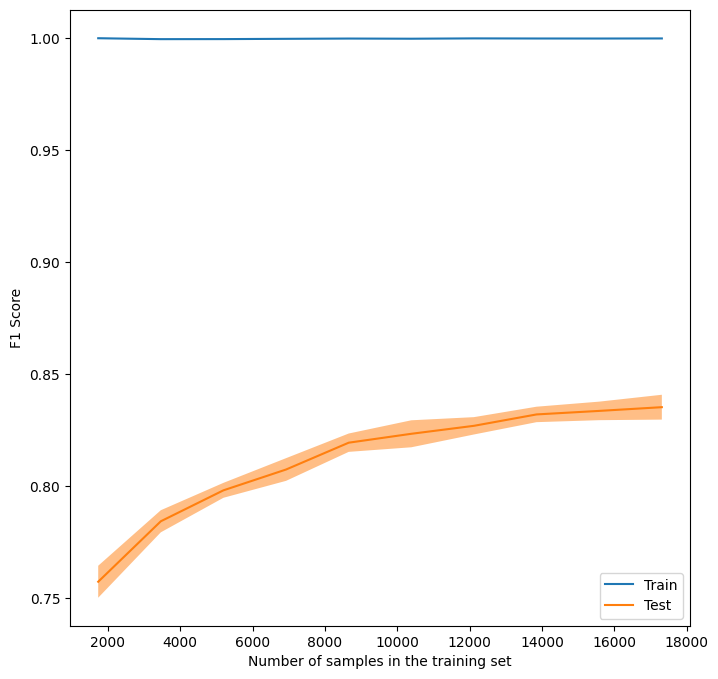

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
lc_displays['rf'].plot(ax=ax)
plt.show()

In [22]:
rf_model = RandomForestClassifier(n_estimators=300, min_samples_split=10,
                       min_samples_leaf=1, max_features='sqrt',
                       max_depth=None, criterion='entropy',
                       class_weight='balanced_subsample',
                       ccp_alpha=0.0, bootstrap=False)
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       criterion='entropy', min_samples_split=10,
                       n_estimators=300)

In [23]:
importances = rf_model.feature_importances_

In [25]:
feature_names = tfidf_vect.get_feature_names_out()

In [26]:
forest_importances = pd.Series(importances, index=feature_names)

In [36]:
imp_10 = forest_importances.sort_values(ascending=False).iloc[:10]

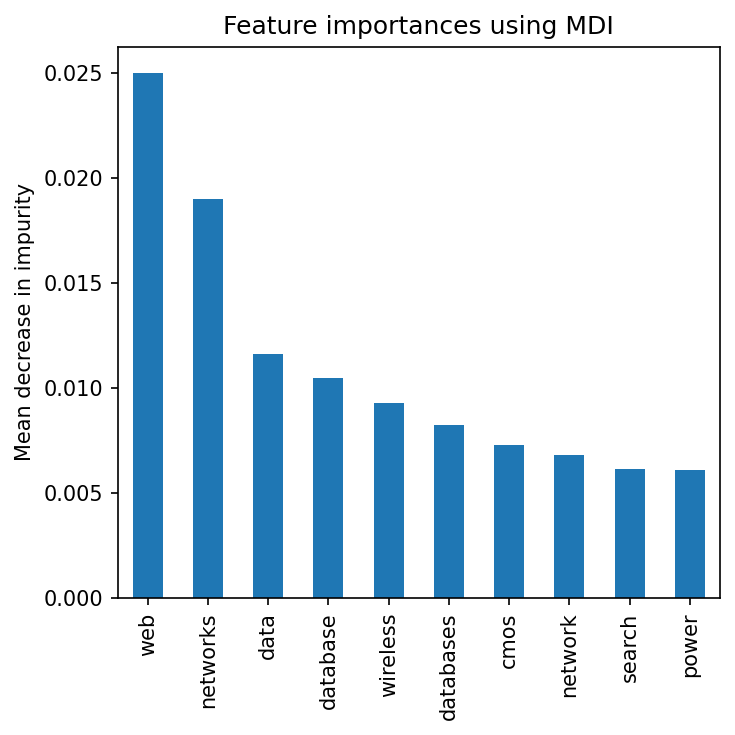

In [41]:
fig, ax = plt.subplots(figsize=(5,5), dpi=150)
imp_10.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()